In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = 'small_321_train.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['small_data']
    train_labels = save['small_target']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (750, 1, 64, 64) (750, 6)


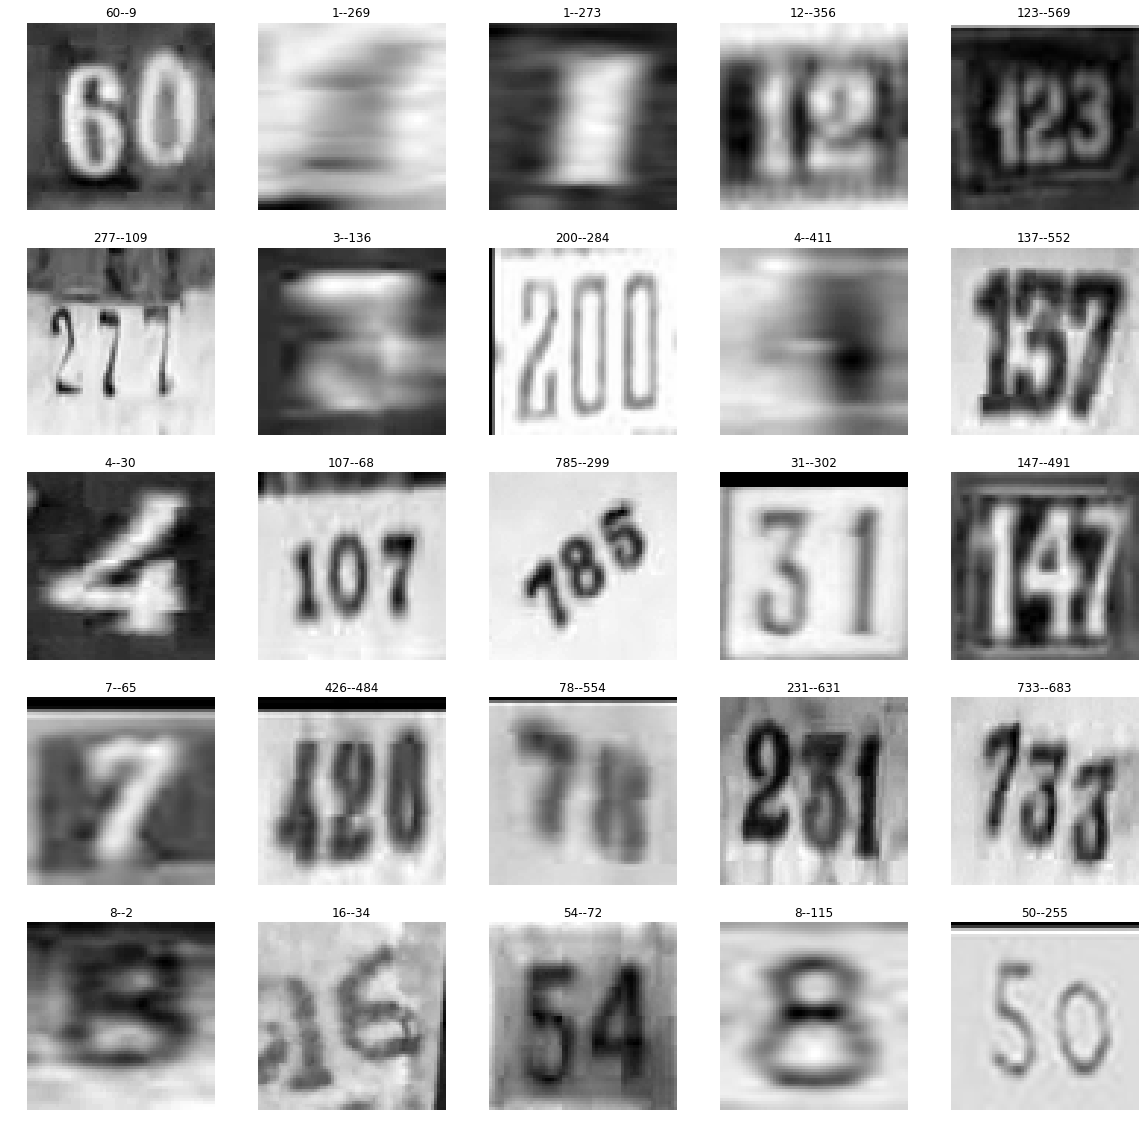

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=5, ncols=5)

im_samples = []

for row in range(5):
    for i, j in enumerate(np.sort(np.random.randint(0, train_labels.shape[0], size=5))):
        im = train_dataset[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(train_labels[j,0]):
            house_num += str(train_labels[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(80)
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(120)
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.bn5 = nn.BatchNorm2d(160)
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.bn6 = nn.BatchNorm2d(200)
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.bn7 = nn.BatchNorm2d(240)
        self.pool = nn.MaxPool2d(2, 2)
        self.FC = nn.Linear(960, 1080)
        self.bn8 = nn.BatchNorm1d(1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        x = self.pool(self.bn7(F.relu(self.conv7(x))))
        x = x.view(-1, 960)
        x = self.bn8(F.relu(self.FC(x)))
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [5]:
net = Net()
net.cuda()
print("!")

!


In [6]:
print(list(net.parameters())[0][0].grad)

None


In [7]:
for param in net.parameters():
    if(param.grad is not None):
        print(param)

In [8]:
data_tensor = torch.from_numpy(train_dataset)
target_tensor = torch.from_numpy(train_labels).type(torch.LongTensor)
print(data_tensor.type(), data_tensor.size())
print(target_tensor.type(), target_tensor.size())

torch.FloatTensor torch.Size([750, 1, 64, 64])
torch.LongTensor torch.Size([750, 6])


In [9]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [18]:
num_epochs = 100
batch_size = 64
num_train = data_tensor.size()[0]
print(num_train)
iter_per_epoch = num_train // batch_size
print_every = 3
print(iter_per_epoch)

750
11


In [19]:
epoch_losses = {i:[] for i in range(num_epochs)}
loss_history = []

In [12]:
net.train()

Net (
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(120, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
  (conv6): Conv2d(160, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
  (conv7): Conv2d(200, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn7): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True)
  (p

In [20]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 110)

    i = 0
    rng_state = torch.get_rng_state()
    new_idxs = torch.randperm(num_train)
    
    t1 = time.time()
    for t in range(iter_per_epoch):
        batch_idxs = new_idxs[i: i+batch_size]
        i += batch_size
        X_batch = data_tensor[batch_idxs]
        Y_batch = target_tensor[batch_idxs][:,0:4]
        lenths = Y_batch[:, 0]
        bin3 = []
        bin2 = []
        bin1 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 1):
                bin1.append(idx)
            elif (lenth == 2):
                bin2.append(idx)
            elif (lenth == 3):
                bin3.append(idx)
        

        X_batch = Variable(X_batch).cuda()
        Y_batch = Variable(Y_batch).cuda()
        optimizer.zero_grad()
        outputs = net(X_batch)
        
        if bin3:
            idxs = torch.LongTensor(bin3).cuda()
            Y = Y_batch[idxs]
            lossl = objective(outputs[0][idxs], Y[:, 0])
            loss1 = objective(outputs[1][idxs], Y[:, 1])
            loss2 = objective(outputs[2][idxs], Y[:, 2])
            loss3 = objective(outputs[3][idxs], Y[:, 3])
            lossd3 = lossl + loss1 + loss2 + loss3
            lossd3.backward(retain_variables=True)
            optimizer.step()
        
        if bin2:
            optimizer.zero_grad()
            idxs = torch.LongTensor(bin2).cuda()
            Y = Y_batch[idxs]
            lossl = objective(outputs[0][idxs], Y[:, 0])
            loss1 = objective(outputs[1][idxs], Y[:, 1])
            loss2 = objective(outputs[2][idxs], Y[:, 2])
            lossd2 = lossl + loss1 + loss2
            lossd2.backward(retain_variables=True)
            optimizer.step()
        
        if bin1:
            optimizer.zero_grad()
            idxs = torch.LongTensor(bin1).cuda()
            Y = Y_batch[idxs]
            lossl = objective(outputs[0][idxs], Y[:, 0])
            loss1 = objective(outputs[1][idxs], Y[:, 1])
            lossd1 = lossl + loss1
            lossd1.backward()
            optimizer.step()
        
        optimizer.step()
        final_loss = lossd3 + lossd2 + lossd1
        
        loss_history.append(final_loss.data[0])
        epoch_losses[epoch].append(final_loss.data[0])
        
        if (t % print_every == 0):
            print('Iteration : ', t+1, ' / ', iter_per_epoch)
            print('loss : ', final_loss.data[0])
            print('loss3d : ', lossd3.data[0], 'loss2d : ', lossd2.data[0], 'loss1d : ', lossd1.data[0])
        
    t2 = time.time()
    print("time taken : ", t2-t1)
    print('-' * 110)
        

Epoch 0/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.029112156480550766
loss3d :  0.014649080112576485 loss2d :  0.011504385620355606 loss1d :  0.00295869167894125
Iteration :  4  /  11
loss :  0.036482248455286026
loss3d :  0.02013366110622883 loss2d :  0.01352018117904663 loss1d :  0.0028284071013331413
Iteration :  7  /  11
loss :  0.03918202966451645
loss3d :  0.02373810112476349 loss2d :  0.013007529079914093 loss1d :  0.002436399459838867
Iteration :  10  /  11
loss :  0.03289094567298889
loss3d :  0.01590704917907715 loss2d :  0.013688473962247372 loss1d :  0.003295421600341797
time taken :  34.66706562042236
--------------------------------------------------------------------------------------------------------------
Epoch 1/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0360581278

loss3d :  0.009071849286556244 loss2d :  0.0045419055968523026 loss1d :  0.0023721412289887667
time taken :  45.71832227706909
--------------------------------------------------------------------------------------------------------------
Epoch 10/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.015617001801729202
loss3d :  0.00783503707498312 loss2d :  0.005650096572935581 loss1d :  0.002131868153810501
Iteration :  4  /  11
loss :  0.01139034889638424
loss3d :  0.005664893426001072 loss2d :  0.004510653670877218 loss1d :  0.0012148022651672363
Iteration :  7  /  11
loss :  0.01768525503575802
loss3d :  0.010251430794596672 loss2d :  0.0070406910963356495 loss1d :  0.0003931339015252888
Iteration :  10  /  11
loss :  0.010039519518613815
loss3d :  0.004606366157531738 loss2d :  0.002929789712652564 loss1d :  0.0025033631827682257
time taken :  46.74090576171875
-----------------------------

Iteration :  7  /  11
loss :  0.010360261425375938
loss3d :  0.0059025101363658905 loss2d :  0.004043351858854294 loss1d :  0.00041439951746724546
Iteration :  10  /  11
loss :  0.007157490588724613
loss3d :  0.003473255317658186 loss2d :  0.002914468292146921 loss1d :  0.0007697668625041842
time taken :  48.89442157745361
--------------------------------------------------------------------------------------------------------------
Epoch 20/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.006672471296042204
loss3d :  0.003336304100230336 loss2d :  0.0029221533332020044 loss1d :  0.0004140138626098633
Iteration :  4  /  11
loss :  0.0056154183112084866
loss3d :  0.002239359775558114 loss2d :  0.002504014875739813 loss1d :  0.000872043427079916
Iteration :  7  /  11
loss :  0.011889439076185226
loss3d :  0.006831073667854071 loss2d :  0.004398321732878685 loss1d :  0.0006600429769605398
Itera

Iteration :  1  /  11
loss :  0.005536749958992004
loss3d :  0.0031175613403320312 loss2d :  0.002198571804910898 loss1d :  0.00022061665367800742
Iteration :  4  /  11
loss :  0.00651973020285368
loss3d :  0.0035118020605295897 loss2d :  0.0027955127879977226 loss1d :  0.0002124150632880628
Iteration :  7  /  11
loss :  0.0066358596086502075
loss3d :  0.004306827671825886 loss2d :  0.0018239550990983844 loss1d :  0.0005050764884799719
Iteration :  10  /  11
loss :  0.0051005687564611435
loss3d :  0.002797230612486601 loss2d :  0.0020079612731933594 loss1d :  0.00029537678346969187
time taken :  50.428399085998535
--------------------------------------------------------------------------------------------------------------
Epoch 30/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0037293292116373777
loss3d :  0.0019663628190755844 loss2d :  0.0012802548008039594 loss1d :  0.0004827117954846

time taken :  48.43203353881836
--------------------------------------------------------------------------------------------------------------
Epoch 39/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.003537785727530718
loss3d :  0.0018815777730196714 loss2d :  0.0015040438156574965 loss1d :  0.00015216403699014336
Iteration :  4  /  11
loss :  0.004640822298824787
loss3d :  0.0026058354414999485 loss2d :  0.0015407667960971594 loss1d :  0.0004942200612276793
Iteration :  7  /  11
loss :  0.00513734295964241
loss3d :  0.0023852649610489607 loss2d :  0.0025671208277344704 loss1d :  0.00018495671974960715
Iteration :  10  /  11
loss :  0.003821368794888258
loss3d :  0.002285480499267578 loss2d :  0.0013332604430615902 loss1d :  0.00020262773614376783
time taken :  48.66650080680847
--------------------------------------------------------------------------------------------------------------
E

Iteration :  7  /  11
loss :  0.003802264342084527
loss3d :  0.0020294571295380592 loss2d :  0.0017004013061523438 loss1d :  7.24058918422088e-05
Iteration :  10  /  11
loss :  0.003716097678989172
loss3d :  0.00237946305423975 loss2d :  0.0012034540995955467 loss1d :  0.00013318061246536672
time taken :  48.3159282207489
--------------------------------------------------------------------------------------------------------------
Epoch 49/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.002838308224454522
loss3d :  0.0016920350026339293 loss2d :  0.0009285970008932054 loss1d :  0.00021767616271972656
Iteration :  4  /  11
loss :  0.003970774821937084
loss3d :  0.0022940989583730698 loss2d :  0.0013325810432434082 loss1d :  0.0003440947621129453
Iteration :  7  /  11
loss :  0.0020774067379534245
loss3d :  0.0010121496161445975 loss2d :  0.0008069900795817375 loss1d :  0.0002582669258117676

Iteration :  1  /  11
loss :  0.0030462476424872875
loss3d :  0.0013855828437954187 loss2d :  0.0015443166485056281 loss1d :  0.0001163482666015625
Iteration :  4  /  11
loss :  0.0018339977832511067
loss3d :  0.0010420936159789562 loss2d :  0.0006933419499546289 loss1d :  9.856224642135203e-05
Iteration :  7  /  11
loss :  0.0016317812260240316
loss3d :  0.00083095149602741 loss2d :  0.0005950927734375 loss1d :  0.0002057368983514607
Iteration :  10  /  11
loss :  0.001890238607302308
loss3d :  0.001142044086009264 loss2d :  0.0005459504900500178 loss1d :  0.00020224398758728057
time taken :  49.649617195129395
--------------------------------------------------------------------------------------------------------------
Epoch 59/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0013514370657503605
loss3d :  0.0007245324086397886 loss2d :  0.0005109423655085266 loss1d :  0.000115962262498214

time taken :  50.25066423416138
--------------------------------------------------------------------------------------------------------------
Epoch 68/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0014848188729956746
loss3d :  0.0006204128731042147 loss2d :  0.0006556964945048094 loss1d :  0.00020870954904239625
Iteration :  4  /  11
loss :  0.002233448438346386
loss3d :  0.0014276669826358557 loss2d :  0.0006282859249040484 loss1d :  0.0001774956181179732
Iteration :  7  /  11
loss :  0.0015159728936851025
loss3d :  0.0007861614576540887 loss2d :  0.0005022684345021844 loss1d :  0.0002275430306326598
Iteration :  10  /  11
loss :  0.001374371349811554
loss3d :  0.0008594513055868447 loss2d :  0.00043275355710648 loss1d :  8.216657442972064e-05
time taken :  48.74734091758728
--------------------------------------------------------------------------------------------------------------
E

Iteration :  7  /  11
loss :  0.0011067589512094855
loss3d :  0.0005951342172920704 loss2d :  0.00042870044126175344 loss1d :  8.292424899991602e-05
Iteration :  10  /  11
loss :  0.0012294311309233308
loss3d :  0.0007169980672188103 loss2d :  0.00045740039786323905 loss1d :  5.5032614909578115e-05
time taken :  48.52253484725952
--------------------------------------------------------------------------------------------------------------
Epoch 78/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0008072073687799275
loss3d :  0.0003771185874938965 loss2d :  0.00031948089599609375 loss1d :  0.00011060787801397964
Iteration :  4  /  11
loss :  0.0009050493827089667
loss3d :  0.0006061744643375278 loss2d :  0.00023224775213748217 loss1d :  6.66271589579992e-05
Iteration :  7  /  11
loss :  0.0017485965508967638
loss3d :  0.0009565536747686565 loss2d :  0.0006452202796936035 loss1d :  0.00014682

Iteration :  1  /  11
loss :  0.0006267066346481442
loss3d :  0.00029526816797442734 loss2d :  0.0002854237100109458 loss1d :  4.601478576660156e-05
Iteration :  4  /  11
loss :  0.001130306045524776
loss3d :  0.00038112292531877756 loss2d :  0.0006208773120306432 loss1d :  0.00012830588093493134
Iteration :  7  /  11
loss :  0.0010643535060808063
loss3d :  0.00041204027365893126 loss2d :  0.00047349926899187267 loss1d :  0.00017881393432617188
Iteration :  10  /  11
loss :  0.0009278467041440308
loss3d :  0.000627705012448132 loss2d :  0.00025306030875071883 loss1d :  4.708139749709517e-05
time taken :  48.74049711227417
--------------------------------------------------------------------------------------------------------------
Epoch 88/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0006657185731455684
loss3d :  0.0002768667181953788 loss2d :  0.00022988850832916796 loss1d :  0.0001589

Iteration :  10  /  11
loss :  0.0006179888732731342
loss3d :  0.0003428459167480469 loss2d :  0.00021367071894928813 loss1d :  6.147225940367207e-05
time taken :  48.468260765075684
--------------------------------------------------------------------------------------------------------------
Epoch 97/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  11
loss :  0.0005345281097106636
loss3d :  0.00026098889065906405 loss2d :  0.00024047851911745965 loss1d :  3.306071084807627e-05
Iteration :  4  /  11
loss :  0.0005196372512727976
loss3d :  0.0003336616209708154 loss2d :  0.00016429208335466683 loss1d :  2.1683543309336528e-05
Iteration :  7  /  11
loss :  0.0005219300510361791
loss3d :  0.00024018288240768015 loss2d :  0.00022109350538812578 loss1d :  6.065368506824598e-05
Iteration :  10  /  11
loss :  0.0006121232872828841
loss3d :  0.00031643820693716407 loss2d :  0.00026361149502918124 loss1d :  3.20

In [21]:
f = open("c321_overfit_longer.pkl", "bw")
torch.save(net.state_dict(), f)
f.close()

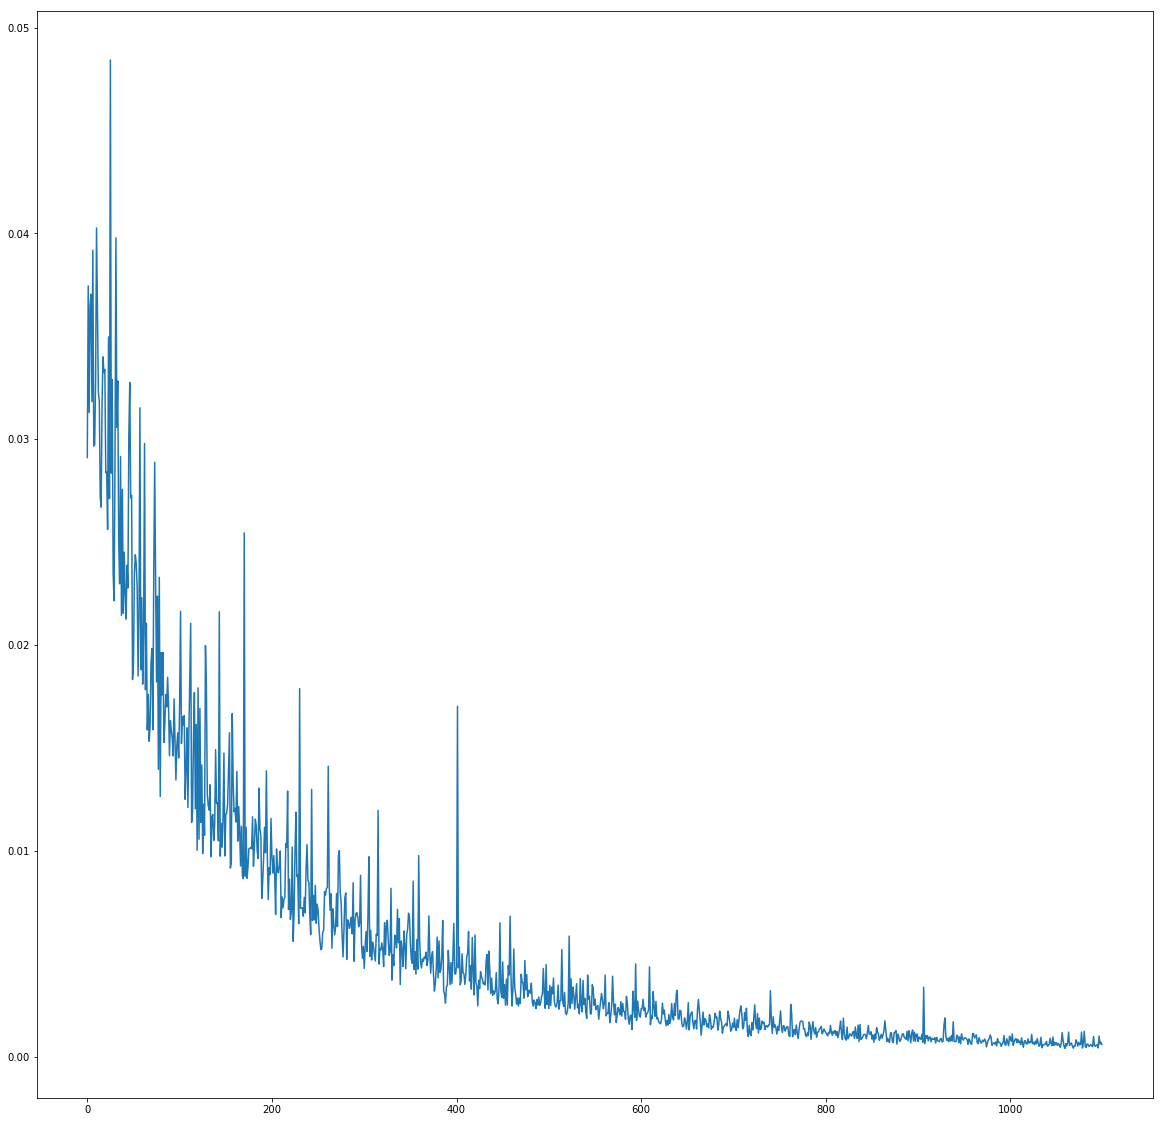

In [22]:
plt.figure()
plt.plot(loss_history)